In [36]:
from torch.autograd import Variable
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Some plot functions

In [37]:
def plot_sphere():
    # Make data
    theta = np.linspace(0, 2 * np.pi, 100)
    phi = np.linspace(0, np.pi, 100)
    x = np.outer(np.cos(theta), np.sin(phi))
    y = np.outer(np.sin(theta), np.sin(phi))
    z = np.outer(np.ones(np.size(theta)), np.cos(phi))

    # Plot the surface
    ax.plot_surface(x, y, z, color='b', alpha=0.2)

def plot_points(l, color='r', s=20):
    l_numpy = [elt.data.numpy() for elt in l]
    xs = [elt[0] for elt in l_numpy]
    ys = [elt[1] for elt in l_numpy]
    zs = [elt[2] for elt in l_numpy]
    #print(xs, ys, zs)
    ax.scatter(xs, ys, zs, color=color, s=s)
    
def plot_geodesic(x, v, color='g'):
    nb_points = 300
    times = Variable(torch.from_numpy(np.linspace(0., 2*np.pi/np.linalg.norm(v.data.numpy()), nb_points)))
    pts = []
    for i in range(nb_points):
        pts.append(exponential(x, v, times[i]))
    plot_points(pts, color='g')

# Utility to go from (theta,phi) to (x,y,z) coordinates

In [38]:
#going from 2d (theta, phi) to 3d (x,y,z)
def to_3d(x_2d):
    x = torch.sin(x_2d[0]) * torch.cos(x_2d[1])
    y = torch.sin(x_2d[0]) * torch.sin(x_2d[1])
    z = torch.cos(x_2d[0])
    return torch.stack([x,y,z]).squeeze()

def to_3d_vector(x_2d, v_2d):
    v_x = torch.cos(x_2d[0])*torch.cos(x_2d[1]) * v_2d[0] - torch.sin(x_2d[0]) * torch.sin(x_2d[1]) * v_2d[1]
    v_y = torch.cos(x_2d[0])*torch.sin(x_2d[1]) * v_2d[0] + torch.sin(x_2d[0]) * torch.cos(x_2d[1]) * v_2d[1]
    v_z = -1. * torch.sin(x_2d[0]) * v_2d[0]
    return torch.stack([v_x, v_y, v_z]).squeeze()
    

## Riemannian exponential on the sphere and geodesic regression loss

In [39]:
#3d expression of geodesic: exp_x(v) = cos(|v|) x + sin(|v|)v/|v|
def exponential(x, v, t=1.):
    x_3d = to_3d(x)
    v_3d = to_3d_vector(x, v)
    norm_v = torch.norm(t * v_3d)
    return torch.cos(norm_v) * x_3d + (torch.sin(norm_v)/norm_v) * (t * v_3d)
   
def geodesic_regression_loss(x, v, times, targets):
    cost = 0
    for i, t in enumerate(times):
        cost += torch.norm(exponential(x, v, float(t)) - targets[i])
    return cost

## Generating data.

In [40]:
#Generating data from a real geodesic.
true_x_2d = np.array([0.5, -1.])
true_v_2d = np.array([0.4, 0.8])
true_x = Variable(torch.from_numpy(true_x_2d))
true_v = Variable(torch.from_numpy(true_v_2d))

times = np.linspace(0.1, 2., 10)
targets = [exponential(true_x, true_v, float(t)) for t in times]


## Defining the optimisation procedure

In [41]:
def geodesic_regression(times, targets, x_2d, v_2d):
    optimizer = torch.optim.Adadelta([x_2d, v_2d])
    for i in range(500):
        optimizer.zero_grad()
        loss = geodesic_regression_loss(x_2d, v_2d, times, targets)
        loss.backward()
        if i == 0:
            print("Initial loss:", loss.data.numpy()[0], "x_2d:", x_2d.data.numpy(), "v_2d:", v_2d.data.numpy())
        optimizer.step()

    print("Final loss:", loss.data.numpy()[0], "x_2d:", x_2d.data.numpy(), "v_2d:", v_2d.data.numpy())
    return x_2d, v_2d

## Optimisation, no noise added

In [42]:
x_2d_numpy = np.array([0.4, -1.])
v_2d_numpy = np.array([0.1, 0.1])
x_2d = Variable(torch.from_numpy(x_2d_numpy), requires_grad=True)
v_2d = Variable(torch.from_numpy(v_2d_numpy), requires_grad=True)

x_2d, v_2d = geodesic_regression(times, targets, x_2d, v_2d)

Initial loss: 5.4098742849845936 x_2d: [ 0.4 -1. ] v_2d: [0.1 0.1]
Final loss: 0.08914507353106864 x_2d: [ 0.494372   -0.99558652] v_2d: [0.38994488 0.75396333]


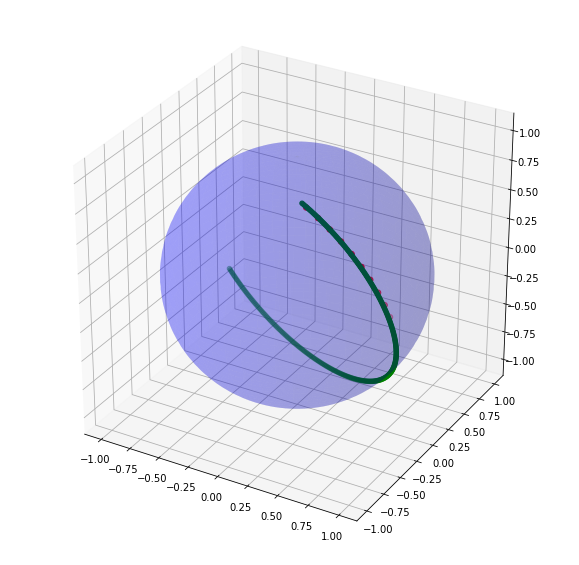

In [43]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
plot_sphere()
plot_points(targets, color='r', s=30)
plot_geodesic(x_2d, v_2d, color='b')
plt.show()

## Optimisation, noise added

In [46]:
#Adding noise
mean = np.zeros((3,))
cov = 0.04 * np.eye(3)
noise = np.random.multivariate_normal(mean, cov, len(targets))
noised_targets = [targets[i] + Variable(torch.from_numpy(noise[i])) for i in range(len(targets))]
noised_targets = [noised_targets[i]/torch.norm(noised_targets[i]) for i in range(len(targets))]

#Optimization with the noise.
x_2d_numpy = np.array([0.1, 0.1])
v_2d_numpy = np.array([0., 0.001])
x_2d = Variable(torch.from_numpy(x_2d_numpy), requires_grad=True)
v_2d = Variable(torch.from_numpy(v_2d_numpy), requires_grad=True)

x_2d, v_2d = geodesic_regression(times, noised_targets, x_2d, v_2d)

Initial loss: 8.59521220833641 x_2d: [0.1 0.1] v_2d: [0.    0.001]
Final loss: 2.696096702658392 x_2d: [ 0.40938511 -1.00237049] v_2d: [0.3919504  0.67389371]


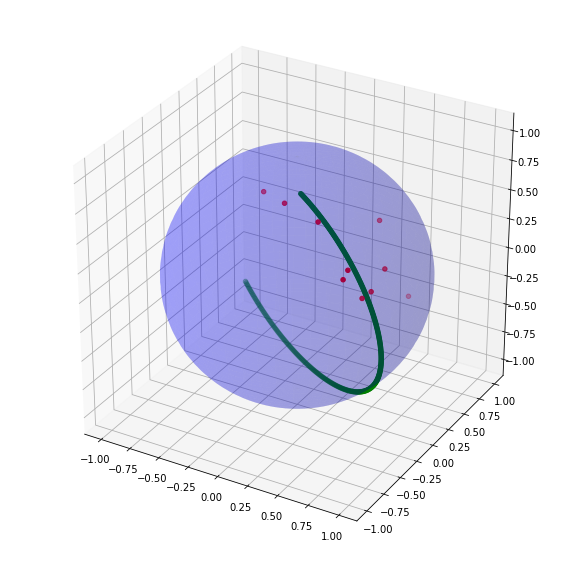

In [47]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
plot_sphere()
plot_points(noised_targets, color='r')
plot_geodesic(x_2d, v_2d, color='b')
plt.show()

# With Hamiltonian integration

In [15]:
def inverse_metric(q):
    #q = [theta, phi]
    a = Variable(torch.Tensor([[1.,0],[0.,0.]]))
    b = Variable(torch.Tensor([[0.,0],[0.,1.]]))
    aux = 1./torch.sin(q[0])**2.
    return a + aux * b

def Hamiltonian(q, p):
    return 0.5 * torch.dot(p, torch.matmul(inverse_metric(q), p))
                              
def dp(q, p):
    return -1. * torch.autograd.grad(Hamiltonian(q, p), q, create_graph=True)[0]
                              
def dq(q, p):
    return torch.matmul(inverse_metric(q), p)
                              
def euler_step(q, p, dt):
    return q + dq(q, p) * dt, p + dp(q, p) * dt

def Riemannian_exponential(q, p):
    traj_q, traj_p = [q], [p]
    nb_points = 50
    dt = 1./nb_points
    for i in range(nb_points - 1):
        new_q, new_p = euler_step(traj_q[-1], traj_p[-1] ,dt)
        traj_q.append(new_q)
        traj_p.append(new_p)
    return traj_q, traj_p                             


In [16]:
q = Variable(torch.Tensor([0.2, 0.3]), requires_grad = True)
p = Variable(torch.Tensor([0.1, 0.2]), requires_grad = True)
traj_q, traj_p = Riemannian_exponential(q,p)


In [17]:
def geodesic_regression_loss(q, p, times, targets):
    traj_q,_ = Riemannian_exponential(q, p)
    cost = 0
    for t in times:
        cost += torch.norm(traj_q[t] - targets[t])
    return cost
    

In [18]:
true_q = Variable(torch.Tensor([0.2, 0.4]), requires_grad = True)
true_p = Variable(torch.Tensor([1.1, 0.6]), requires_grad = True)
true_traj_q, _ = Riemannian_exponential(true_q, true_p)                             
times = np.array([0, 4, 5, 6, 7, 9], dtype=int)
targets = true_traj_q
                                
#print(geodesic_regression_cost(q, p, times, targets))


In [19]:
def geodesic_regression(q, times, targets):
    nb_steps = 100
    p = Variable(torch.Tensor([0., 0.]), requires_grad = True)
    optimizer = torch.optim.Adadelta([p])
    for i in range(nb_steps):
        optimizer.zero_grad()
        loss = geodesic_regression_loss(q, p, times, targets)
        loss.backward(retain_graph = True)
        print("Loss:", loss.data.numpy()[0], "p", p.data.numpy())
        return loss   
    return q, p

In [20]:
_, estimated_p = geodesic_regression(q, times, targets)
print(estimated_p)

Loss: 5.855747 p [0. 0.]


ValueError: not enough values to unpack (expected 2, got 1)